# DCEM optimizer

In this tutorial we take the example from `02_differentiating_theseus_layer.ipynb` and use DCEM optimizer to solve the optimiztion problem

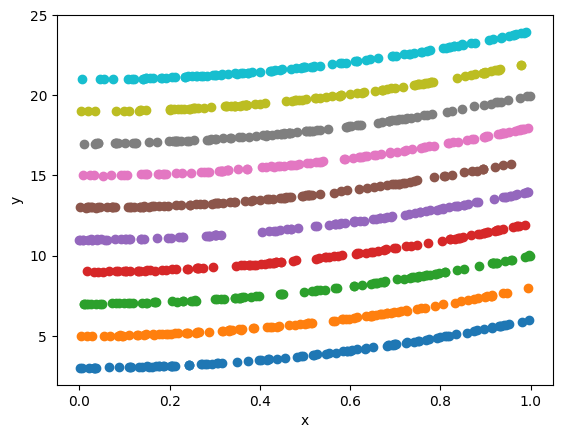

In [1]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(0)

def generate_data(num_points=100, a=1, b=0.5, noise_factor=0.01):
    # Generate data: 100 points sampled from the quadratic curve listed above
    data_x = torch.rand((1, num_points))
    noise = torch.randn((1, num_points)) * noise_factor
    data_y = a * data_x.square() + b + noise
    return data_x, data_y

def generate_learning_data(num_points, num_models):
    a, b = 3, 1
    data_batches = []
    for i in range(num_models):
        b = b + 2
        data = generate_data(num_points, a, b)
        data_batches.append(data)
    return data_batches

num_models = 10
data_batches = generate_learning_data(100, num_models)

fig, ax = plt.subplots()
for i in range(num_models):
    ax.scatter(data_batches[i][0], data_batches[i][1])
ax.set_xlabel('x');
ax.set_ylabel('y');

In [2]:
import theseus as th

data_x, data_y = data_batches[0]
x = th.Variable(data_x, name="x")
y = th.Variable(data_y, name="y")
a = th.Vector(1, name="a")
b = th.Vector(1, name="b")

# Note 'b' is the only optim_var, and 'a' is part of aux_vars
optim_vars = [b]
aux_vars = a, x, y

# updated error function reflects change in 'a'
def quad_error_fn2(optim_vars, aux_vars):
    [b] = optim_vars 
    a, x, y = aux_vars
    est = a.tensor * x.tensor.square() + b.tensor
    err = y.tensor - est
    return err

cost_function = th.AutoDiffCostFunction(
    optim_vars, quad_error_fn2, 100, aux_vars=aux_vars, name="quadratic_cost_fn"
)
objective = th.Objective()
objective.add(cost_function)
optimizer = th.DCEM(
    objective,
    max_iterations=50,
    n_sample=50,
    n_elite=5,
    init_sigma=1.0
)
theseus_optim = th.TheseusLayer(optimizer)

# The value for Variable 'a' is optimized by PyTorch backpropagation
# a_tensor = torch.nn.Parameter(torch.tensor([[3.0]]))
a_tensor = torch.nn.Parameter(torch.rand(1, 1))
model_optimizer = torch.optim.Adam([a_tensor], lr=0.1)


In [3]:
num_batches = len(data_batches)
num_epochs = 20

print(f"Initial a value: {a_tensor.item()}")

for epoch in range(num_epochs):
    epoch_loss = 0.
    epoch_b = []  # keep track of the current b values for each model in this epoch
    for i in range(num_batches):
        model_optimizer.zero_grad()
        data_x, data_y = data_batches[i]
        # Step 2.1: Create input dictionary for TheseusLayer, pass to forward function
        # The value for variable `a` is the updated `a_tensor` by Adam
        # Since we are always passing the same tensor, this update is technically redundant, 
        # we include it to explicitly illustrate where variable values come from.
        # An alternative way to do this (try it!)
        # would be to call `a.update(a_tensor)` before the learning loop starts
        # and just let Adam change its value under the hood (i.e., update only `x`, `y`, and `b`
        # inside the loop)
        theseus_inputs = {
            "a": a_tensor,
            "x": data_x,
            "y": data_y,
            "b": torch.ones((1, 1), requires_grad=True)+ 2*i,
        }
        updated_inputs, info = theseus_optim.forward(theseus_inputs)
    
        epoch_b.append(updated_inputs["b"].item())  # add the optimized "b" of the current batch to `epoch_b` list. 
                                                    # Note: here, we do not track the best solution, as we 
                                                    # backpropagate through the entire optimization sequence.
        # Step 2.2: Update objective function with updated inputs
        # objective.update(updated_inputs)
        # updated_inputs["b"].backward()
        # print(a_tensor.grad)
        
        loss = cost_function.error().square().mean()
        # loss = (data_y - a_tensor*data_x.square() - updated_inputs["b"]).square().mean()
        # Step 2.3: PyTorch backpropagation
        loss.backward()
        model_optimizer.step()

        loss_value = loss.item()
        epoch_loss += loss_value
    print(f"Epoch: {epoch} Loss: {epoch_loss}")
    if epoch % 5 == 4:
        print(f" ---------------- Solutions at Epoch {epoch:02d} -------------- ")
        print(" a value:", a.tensor.item())
        print(" b values: ", epoch_b)
        print(f" ----------------------------------------------------- ")

Initial a value: 0.8671661019325256
Epoch: 0 Loss: 2.550168052315712
Epoch: 1 Loss: 0.5709342658519745
Epoch: 2 Loss: 0.026516896905377507
Epoch: 3 Loss: 0.041502360021695495
Epoch: 4 Loss: 0.03600340697448701
 ---------------- Solutions at Epoch 04 -------------- 
 a value: 3.1209044456481934
 b values:  [2.9213318824768066, 4.931384563446045, 6.923666477203369, 8.922560691833496, 10.92679214477539, 12.9524507522583, 14.93254280090332, 16.946014404296875, 18.94110679626465, 20.95488929748535]
 ----------------------------------------------------- 
Epoch: 5 Loss: 0.0052526450890582055
Epoch: 6 Loss: 0.002356653625611216
Epoch: 7 Loss: 0.00257078098366037
Epoch: 8 Loss: 0.0010993483665515669
Epoch: 9 Loss: 0.0010872603015741333
 ---------------- Solutions at Epoch 09 -------------- 
 a value: 3.011151075363159
 b values:  [2.997594118118286, 4.999783992767334, 6.998528480529785, 8.995436668395996, 10.997220039367676, 12.997790336608887, 14.997166633605957, 16.995023727416992, 18.9946556

In [4]:
print(optim_vars)
print(epoch_b)

[Vector(dof=1, tensor=tensor([[20.9990]], grad_fn=<SliceBackward0>), name=b)]
[3.000244617462158, 5.002840042114258, 7.00171422958374, 8.999937057495117, 11.000493049621582, 12.999377250671387, 14.999673843383789, 17.000186920166016, 18.998689651489258, 20.998973846435547]


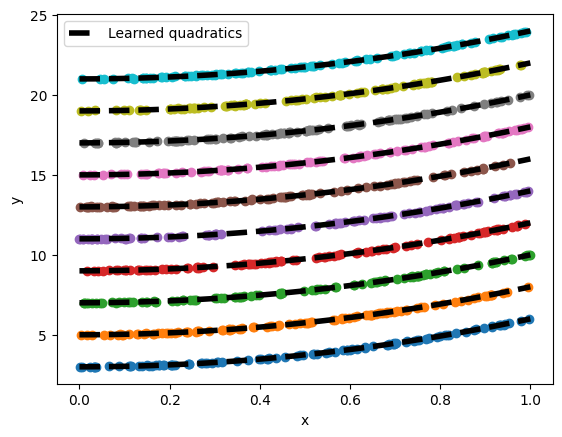

In [5]:
# Plot the learned functions
fig, ax = plt.subplots()

for i in range(num_models):
    ax.scatter(data_batches[i][0], data_batches[i][1])

    a_ = a.tensor.squeeze().detach()
    b = epoch_b[i]
    x = torch.linspace(0., 1., steps=100)
    y = a_*x*x + b
    ax.plot(x, y, color='k', lw=4, linestyle='--',
            label='Learned quadratics' if i == 0 else None)
ax.legend()

ax.set_xlabel('x');
ax.set_ylabel('y');
